# Can we cluster clients from their spending curves?

The initial question is: how can we "cluster" curves using ML? As an example, looking at the spending curve of clients for three different products, we see three distinct curves. Can we use this information to group clients? 

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Initial Observation

We generate sample of curves and see how different they are. We measure their "proximity" using cosine similarity and we also use dimensional reduction to see if the clusters are indeed different among themselves.

### Creating Data

In [150]:
def generate_spending_cuve(x, amplitude=1, period=12, func=np.cos, error=0.1):


    c = amplitude * (2 + func(2 * np.pi * x / period) + np.random.normal(scale=error))

    return c

In [172]:
# Defining size of the groups
group_size = [100, 200, 150]

# Given the groups their own spending curves
g1 = lambda x: generate_spending_cuve(x, amplitude=np.random.randint(10, high=100), period=3, func=np.cos, error=0.1)
g2 = lambda x: generate_spending_cuve(x, amplitude=np.random.randint(20, high=500), period=3, func=np.sin, error=0.2)
g3 = lambda x: generate_spending_cuve(x, amplitude=np.random.randint(5, high=500), period=6, func=np.cos, error=0.3)

# Generating the data
data = []
y = []

for g, n in zip([g1, g2, g3], group_size):
    
    data.extend([[g(x) for x in range(12)] for _ in range(n)])
    y.extend([group_size.index(n)] * n)

# Create a Pandas DF for easier plotting/manipulation
df = pd.DataFrame(data)
df['label'] = y

### Analyzing the differences

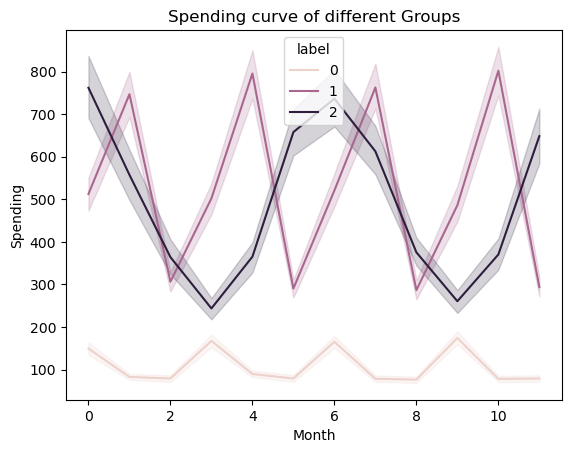

In [173]:
df_melt = df.melt(
    id_vars='label',
    var_name='month',
    value_name='spending'
)


ax = sns.lineplot(data=df_melt, x='month', y='spending', hue='label')

ax.set(
    title='Spending curve of different Groups',
    xlabel='Month',
    ylabel='Spending'
)

plt.show()

In [174]:
# We can check how similar the groups are among themselves and wrt the other groups
from sklearn.metrics.pairwise import cosine_similarity

for i in range(len(group_size)):
    # Compute pairwise cosine similarity
    similarity_matrix = cosine_similarity(df[df['label'] == i].drop(columns='label'))
    print("The cosine similarity between members of group {}: {:2f} +- {:2f}".format(i, similarity_matrix.mean(), similarity_matrix.std()))

for i in range(len(group_size)):
    for j in range(len(group_size)):
        if i < j:
            # Compute pairwise cosine similarity
            similarity_matrix = cosine_similarity(
                df[df['label'] == i].drop(columns='label'),
                df[df['label'] == j].drop(columns='label')
            )
            print("The cosine similarity between group {} and group {}: {:2f} +- {:2f}".format(i, j, similarity_matrix.mean(), similarity_matrix.std()))

The cosine similarity between members of group 0: 0.832487 +- 0.076454
The cosine similarity between members of group 1: 0.793518 +- 0.095578
The cosine similarity between members of group 2: 0.754504 +- 0.105847
The cosine similarity between group 0 and group 1: 0.717704 +- 0.097160
The cosine similarity between group 0 and group 2: 0.696632 +- 0.103803
The cosine similarity between group 1 and group 2: 0.679258 +- 0.106496


In [164]:
#  We see that the groups with larger error have less similarity, but they are still distinct.

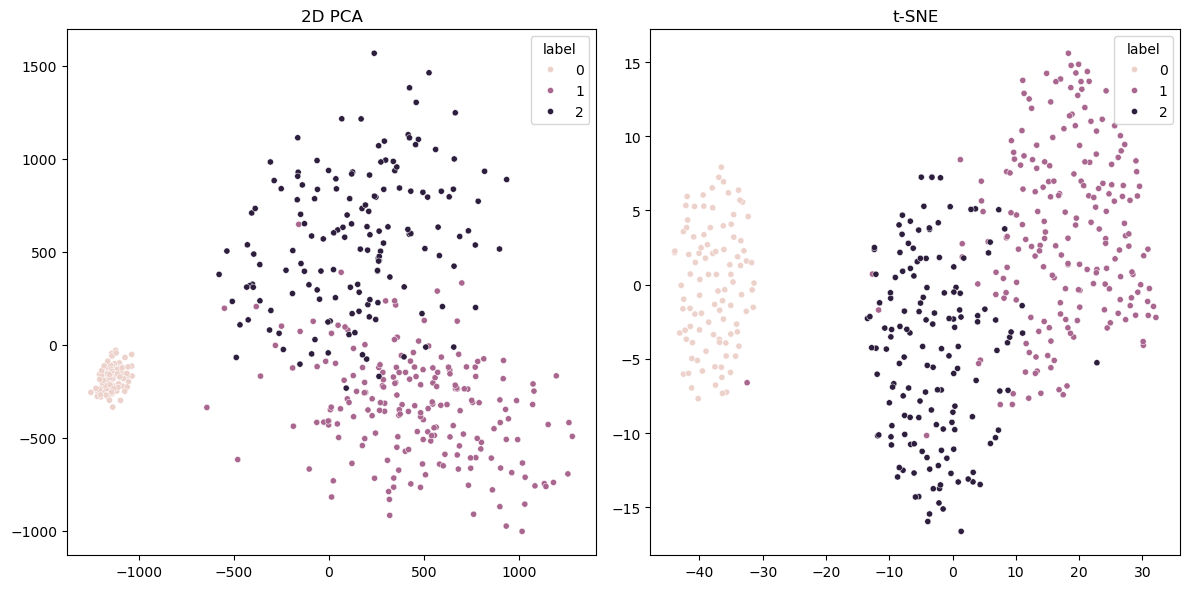

In [182]:
# Can we see the clusters using dimensional reduction?
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X = df.drop(columns='label')
y = df['label']

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# t-SNE embedding
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, s=20, ax=ax[0])
ax[0].set(
    title='2D PCA'
)

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, s=20, ax=ax[1])
ax[1].set(
    title='t-SNE'
)

fig.tight_layout()

plt.show()

In [183]:
# While the first cluster is quite distinct, due to noise, we see the other two clusters rather mixed.

## Modeling

### KNN

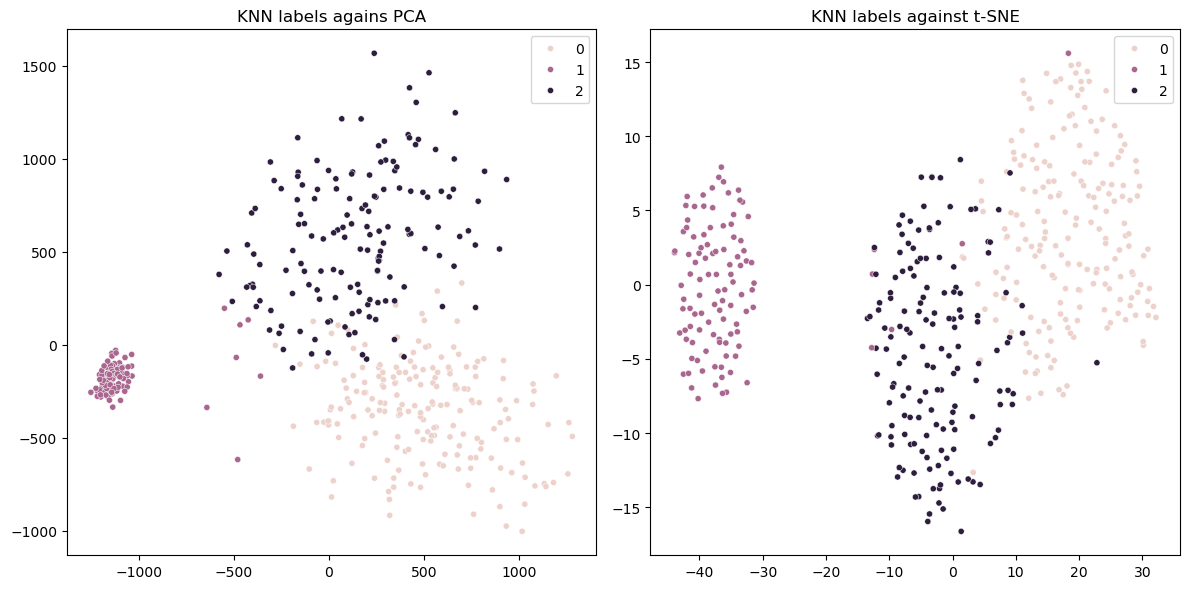

In [188]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scaler = StandardScaler()
knn = KMeans(n_clusters=3)

knn_pipeline = Pipeline(
    [('scaler', scaler),
     ('knn', knn)]
)

knn_pipeline.fit(X)

l = knn_pipeline.predict(X)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=l, s=20, ax=ax[0])
ax[0].set(
    title='KNN labels agains PCA'
)

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=l, s=20, ax=ax[1])
ax[1].set(
    title='KNN labels against t-SNE'
)

fig.tight_layout()

plt.show()

### DBSCAN

In [219]:
from sklearn.metrics import pairwise_distances

dists = pairwise_distances(StandardScaler().fit_transform(X_pca))
print("Min dist:", dists[dists > 0].min())
print("Max dist:", dists.max())
print("Mean dist:", dists.mean())

Min dist: 0.0008411663799609133
Max dist: 5.311673028216468
Mean dist: 1.7604923362789946


In [220]:
from sklearn.metrics import pairwise_distances

dists = pairwise_distances(StandardScaler().fit_transform(X_tsne))
print("Min dist:", dists[dists > 0].min())
print("Max dist:", dists.max())
print("Mean dist:", dists.mean())

Min dist: 0.0036787037
Max dist: 4.9636183
Mean dist: 1.7809634


In [189]:
from sklearn.cluster import DBSCAN

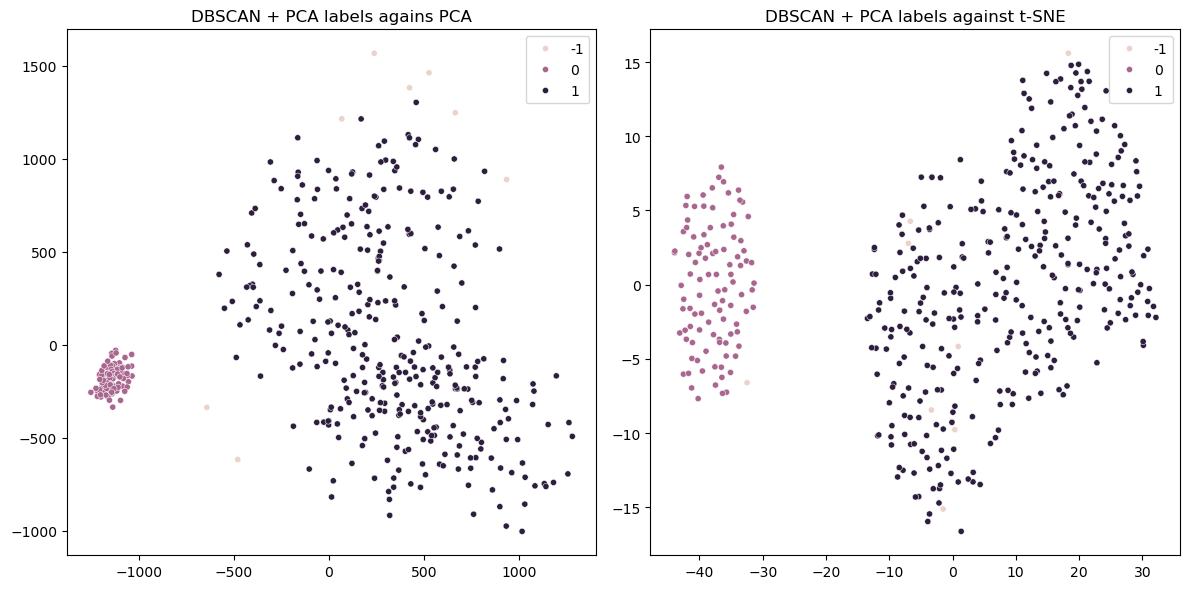

In [226]:
# DBSCAN doesn't work in low density clusters, and since we have a large dimensionality, it's curse.
# To avoid issues, we use PCA for 2/3 dimension and t-SNE

dbscan_pca = Pipeline(
    [
        ('pca', PCA(n_components=2)),
        ('scaler', StandardScaler()),
        ('dbscan', DBSCAN(eps=0.4, min_samples=10, metric='euclidean'))]
)

# dbscan_pca.fit(X)

l = dbscan_pca.fit_predict(X)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=l, s=20, ax=ax[0])
ax[0].set(
    title='DBSCAN + PCA labels agains PCA'
)

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=l, s=20, ax=ax[1])
ax[1].set(
    title='DBSCAN + PCA labels against t-SNE'
)

fig.tight_layout()

plt.show()

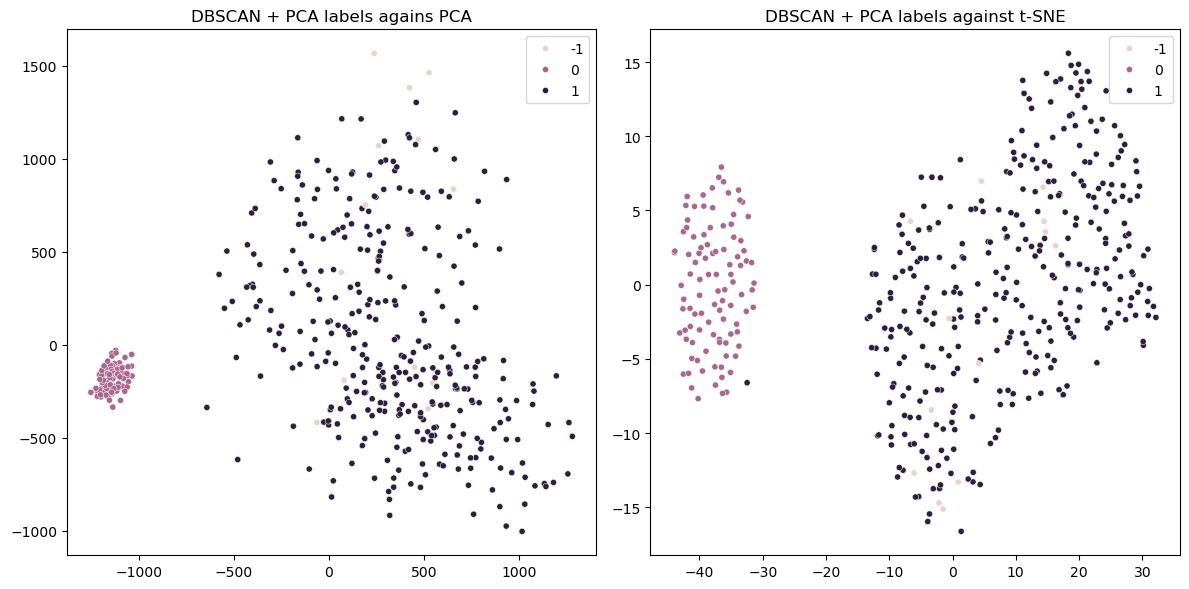

In [229]:
# DBSCAN doesn't work in low density clusters, and since we have a large dimensionality, it's curse.
# To avoid issues, we use PCA for 2/3 dimension and t-SNE

dbscan_pca = Pipeline(
    [
        ('pca', PCA(n_components=3)),
        ('scaler', StandardScaler()),
        ('dbscan', DBSCAN(eps=0.8, min_samples=10, metric='euclidean'))]
)

# dbscan_pca.fit(X)

l = dbscan_pca.fit_predict(X)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=l, s=20, ax=ax[0])
ax[0].set(
    title='DBSCAN + PCA labels agains PCA'
)

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=l, s=20, ax=ax[1])
ax[1].set(
    title='DBSCAN + PCA labels against t-SNE'
)

fig.tight_layout()

plt.show()

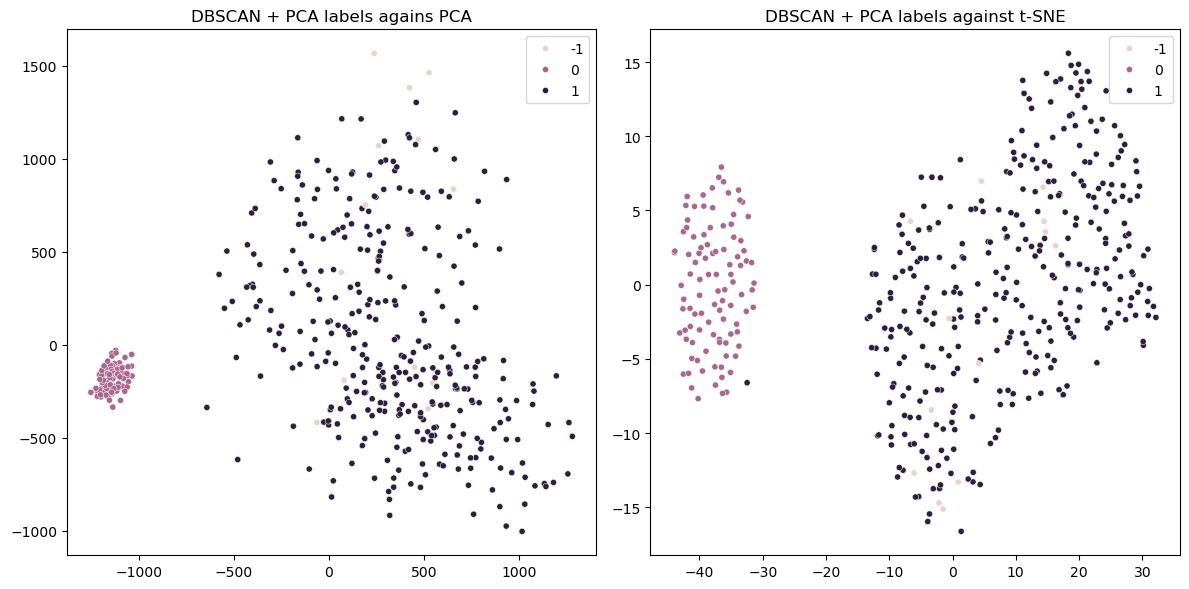

In [233]:
# DBSCAN doesn't work in low density clusters, and since we have a large dimensionality, it's curse.
# To avoid issues, we use PCA for 2/3 dimension and t-SNE

dbscan_tsne = Pipeline(
    [
        ('tsne', TSNE(n_components=2, random_state=42)),
        ('scaler', StandardScaler()),
        ('dbscan', DBSCAN(eps=0.2, min_samples=20, metric='euclidean'))]
)

# dbscan_pca.fit(X)

l = dbscan_pca.fit_predict(X)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=l, s=20, ax=ax[0])
ax[0].set(
    title='DBSCAN + PCA labels agains PCA'
)

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=l, s=20, ax=ax[1])
ax[1].set(
    title='DBSCAN + PCA labels against t-SNE'
)

fig.tight_layout()

plt.show()

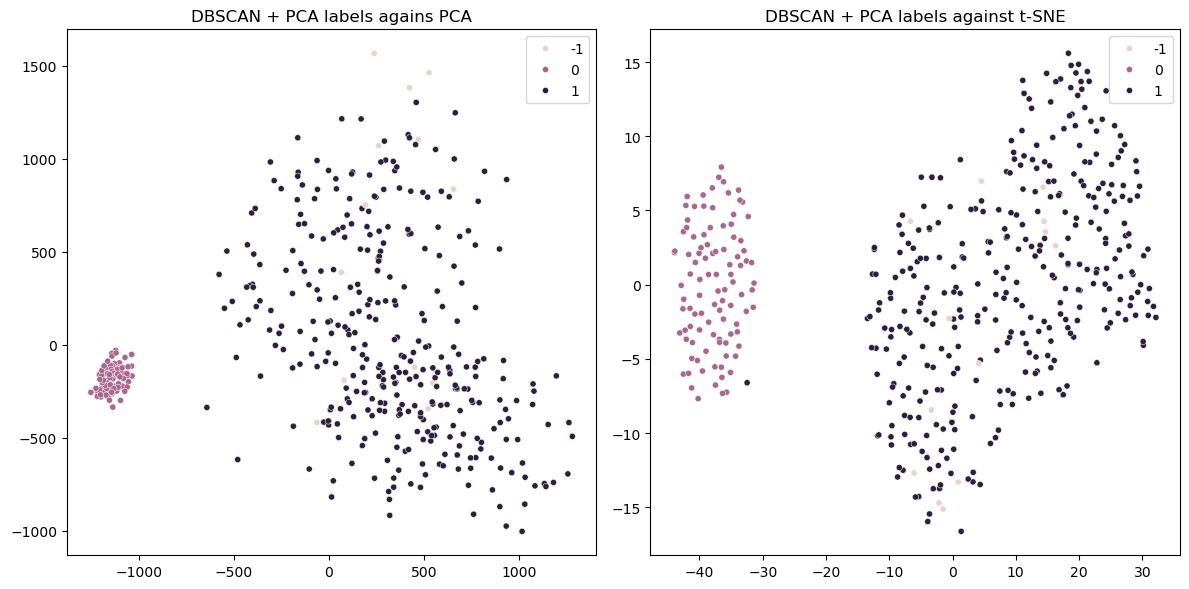

In [232]:
# DBSCAN doesn't work in low density clusters, and since we have a large dimensionality, it's curse.
# To avoid issues, we use PCA for 2/3 dimension and t-SNE

dbscan_tsne = Pipeline(
    [
        ('tsne', TSNE(n_components=3, random_state=42)),
        ('scaler', StandardScaler()),
        ('dbscan', DBSCAN(eps=0.2, min_samples=20, metric='euclidean'))]
)

# dbscan_pca.fit(X)

l = dbscan_pca.fit_predict(X)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=l, s=20, ax=ax[0])
ax[0].set(
    title='DBSCAN + PCA labels agains PCA'
)

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=l, s=20, ax=ax[1])
ax[1].set(
    title='DBSCAN + PCA labels against t-SNE'
)

fig.tight_layout()

plt.show()

### GMM

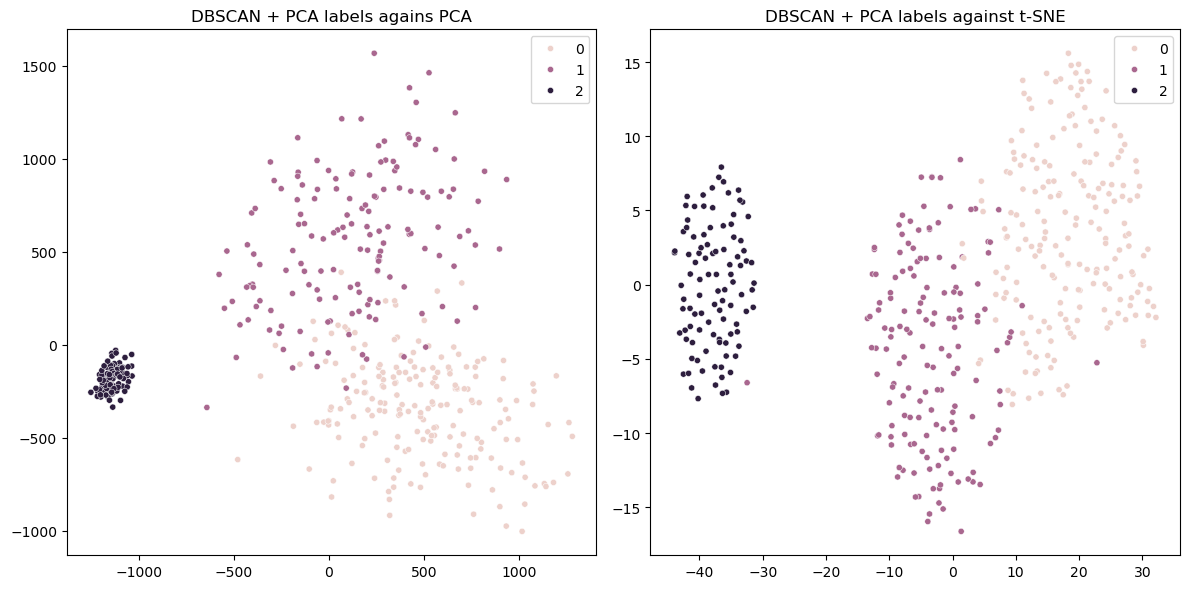

In [211]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
l = gmm.fit_predict(X)

# Plotting
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=l, s=20, ax=ax[0])
ax[0].set(
    title='DBSCAN + PCA labels agains PCA'
)

sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=l, s=20, ax=ax[1])
ax[1].set(
    title='DBSCAN + PCA labels against t-SNE'
)

fig.tight_layout()

plt.show()

## Conclusions

Bot KNN and GMM can find the three clusters, while DBSCAN seems to struggle, which is reasonable, since the noise groups are quite intertwined.